# Data preprocessing

## 1. Packages

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils import utils

## 3. re-format model input

In [3]:
# utils.read_metro_data("data/original_metro_data/臺北捷運每日分時各站OD流量統計資料_202001.csv")
# utils.read_covid_case_data("data/original_covid_data/covidtable_taiwan_cdc4_all.csv")

In [4]:
metro_data_path = [
    "data/original_metro_data/臺北捷運每日分時各站OD流量統計資料_" + str(year) + "{:02d}".format(month) + ".csv"
    for year in [2020, 2021] for month in range(1, 13)
][:-7]

In [5]:
metro_data_list = []
for sub_path in tqdm(metro_data_path): metro_data_list.append(utils.read_metro_data(sub_path))
metro_data = pd.concat(metro_data_list)
del metro_data_list

100%|██████████| 17/17 [03:25<00:00, 12.10s/it]


In [6]:
covid_data = utils.read_covid_case_data("data/original_covid_data/covidtable_taiwan_cdc4_all.csv")

In [43]:
for day in tqdm(range(7)):
    if day == 0:
        all_data = pd.merge(metro_data, covid_data, how="left", left_on=["lag_" + str(day+1)], right_index=True).fillna(0)
    else:
        all_data = pd.merge(all_data, covid_data, how="left", left_on=["lag_" + str(day+1)], right_index=True).fillna(0)
    all_data.columns = list(all_data.columns[:-4]) + ["lag_"+str(day+1)+"_v" + str(i+1) for i in range(4)]

100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


In [8]:
# Keep number, drop merge key
all_data = all_data[list(all_data.columns)[0:4] + list(all_data.columns)[11:]]

In [8]:
all_data.to_csv("data/all_metro_covid_data_202001_202105.csv", index=False)

In [9]:
uniq_time = all_data["time"].unique()

X = [
    all_data.loc[all_data["time"] == sub_time, list(all_data.columns)[2:]].to_numpy()
    for sub_time in tqdm(uniq_time)
]
X_array = np.array(X)

100%|██████████| 10859/10859 [01:01<00:00, 175.36it/s]


In [24]:
# np.save('./data/metro_covid_np_data_total_flow',X_array)

In [36]:
np.save('./data/metro_covid_np_data_total_flow_202001_to_202105', X_array)

In [37]:
np.save('./data/metro_covid_np_data_total_flow_202001_to_202104_without_covid_info',X_array[:,:,:2])

# Visualization

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [48]:
# 考慮metro data只有公佈到4月
covid_data = covid_data[pd.to_datetime(covid_data.index.astype(str)) < np.datetime64("2021-05-01")]
time_ = pd.to_datetime(covid_data.index.astype(str)).to_numpy()

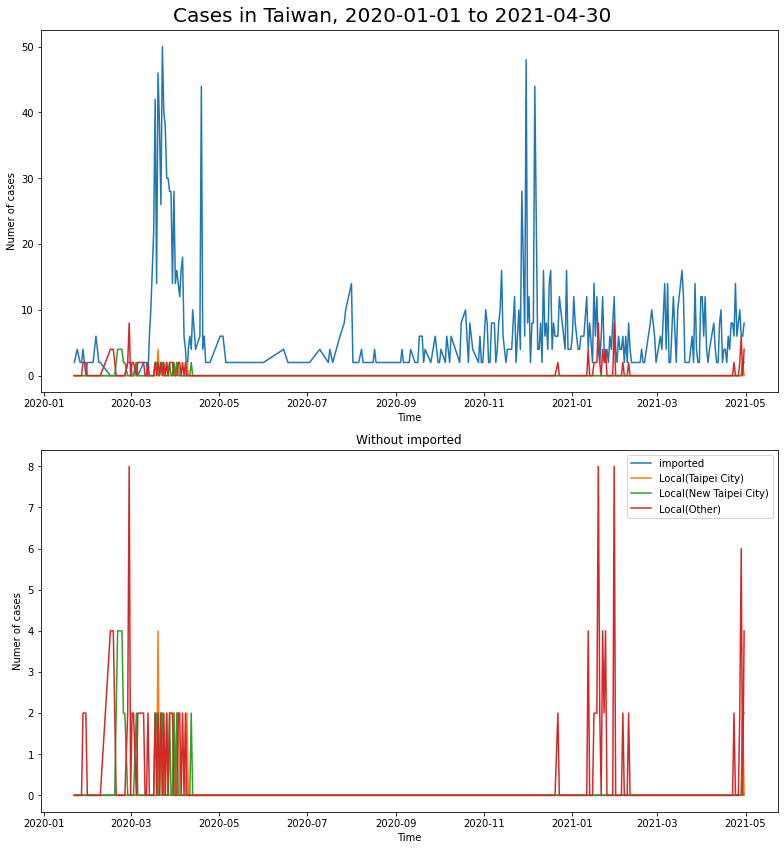

In [59]:
fig, axs = plt.subplots(nrows=2, figsize=(11, 12))

axs[0].set_xlabel("Time") 
axs[0].set_ylabel("Numer of cases") 

axs[0].plot(time_, covid_data['境外移入'].to_numpy(),label='imported')
axs[0].plot(time_, covid_data['台北市'].to_numpy(),label='Local(Taipei City)')
axs[0].plot(time_, covid_data['新北市'].to_numpy(),label='Local(New Taipei City)')
axs[0].plot(time_, covid_data['其他縣市'].to_numpy(),label='Local(Other)')

axs[1].set_title("Without imported")
axs[1].set_xlabel("Time") 
axs[1].set_ylabel("Numer of cases") 

axs[1].plot(time_, [0]*len(time_), label='imported')
axs[1].plot(time_, covid_data['台北市'].to_numpy(), label='Local(Taipei City)')
axs[1].plot(time_, covid_data['新北市'].to_numpy(), label='Local(New Taipei City)')
axs[1].plot(time_, covid_data['其他縣市'].to_numpy(), label='Local(Other)')

plt.suptitle("Cases in Taiwan, 2020-01-01 to 2021-04-30", size=20)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

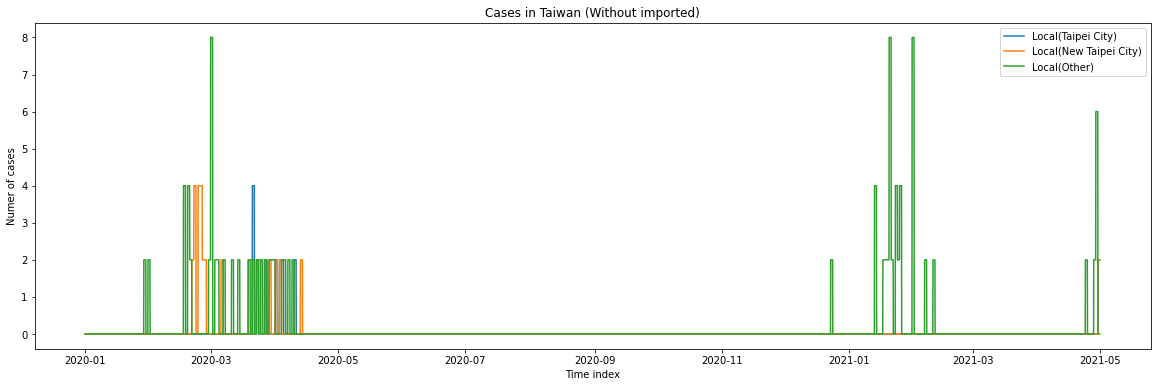